<a href="https://colab.research.google.com/github/JustinBakerMath/conf/blob/master/Lecture_6_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Introduction

This notebook accompanies lecture 6. Some sections are directly related to what we'll discuss in class, whereas other sections are somewhat tangential explorations of related topics.

In [ ]:
# Standard imports
import os
import cv2
import numpy as np
import pandas as pd
import numpy.linalg as la
import numpy.random as npr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## 2. Finding the SVD using numpy
The following code blocks demonstrate how to use numpy to find the singular values and vectors of a matrix.

In [ ]:
# Demo SVD for small matrix
A = np.random.randn(4,3)
A

array([[-1.70203492,  0.95322522,  1.19082021],
       [-1.65684659,  0.0763927 , -1.20222235],
       [-2.03352877, -1.00912774,  1.73184996],
       [ 0.4059686 ,  0.55934287, -1.22884662]])

In [ ]:
[U,S,VT] = la.svd(A, full_matrices=False)

In [ ]:
U

array([[-0.54020125, -0.1943303 ,  0.81833932],
       [-0.16394549, -0.88504126, -0.32792348],
       [-0.7650954 ,  0.17005765, -0.45046701],
       [ 0.30973135, -0.38732169,  0.14094829]])

In [ ]:
S

array([3.61346615, 2.15766301, 1.35937596])

In [ ]:
Sigma = np.diag(S)
Sigma

array([[3.61346615, 0.        , 0.        ],
       [0.        , 2.15766301, 0.        ],
       [0.        , 0.        , 1.35937596]])

In [ ]:
VT.T

array([[ 0.79498701,  0.59975862,  0.09102339],
       [ 0.11564169, -0.29713016,  0.94780835],
       [-0.59550202,  0.74296922,  0.30557171]])

In class we claimed that $A = U\Sigma V^{\top}$. Let's check this!

In [ ]:
reconstruct_A = U@np.diag(S)@VT
reconstruct_A

array([[-1.70203492,  0.95322522,  1.19082021],
       [-1.65684659,  0.0763927 , -1.20222235],
       [-2.03352877, -1.00912774,  1.73184996],
       [ 0.4059686 ,  0.55934287, -1.22884662]])

In [ ]:
A

array([[-1.70203492,  0.95322522,  1.19082021],
       [-1.65684659,  0.0763927 , -1.20222235],
       [-2.03352877, -1.00912774,  1.73184996],
       [ 0.4059686 ,  0.55934287, -1.22884662]])

## 3. First Singular vector as line of best fit
Let's generate some example data in two dimensions (so that we can see it) and then examine the first right singular vector of this data. As we'll see when discussing PCA, this vector gives the direction of the line of best fit for the data.

(1000, 2)


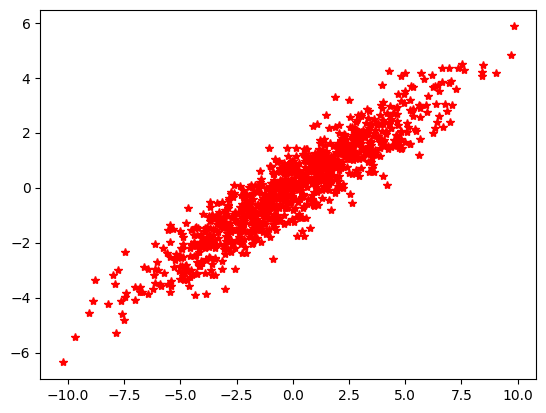

In [ ]:
# Generate data points in 2D plane
fig = plt.figure()
Covariance_Matrix = np.array([[10,5],[5,3]])
center = [0,0]
Data = npr.multivariate_normal(center,Covariance_Matrix,1000)
plt.plot(Data[:,0],Data[:,1],'r*')
print(Data.shape)
plt.show()

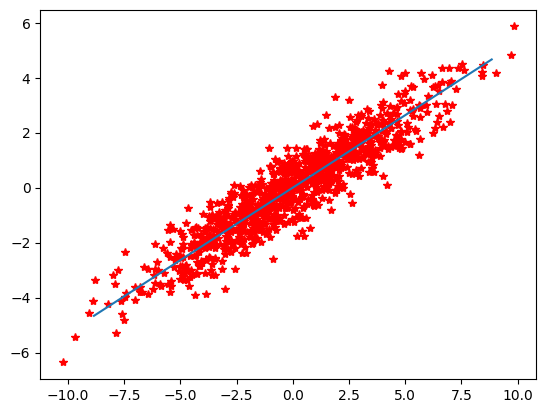

In [ ]:
## Now let's find the leading singular vector
[U,S,VT] = la.svd(Data, full_matrices=False)
v1 = VT[0,:].T
Line_of_best_fit = np.zeros([10000,2])
i = 0
# now plot line {tv_1 : for -10< t< 10}
for t in np.linspace(-10,10,10000):
    Line_of_best_fit[i,:] = t*v1
    i +=1
plt.plot(Data[:,0],Data[:,1],'r*',Line_of_best_fit[:,0],Line_of_best_fit[:,1])
plt.show()

Note. In this example, we did not center the data before applying SVD for PCA is because it is already centered.

Let's now take a look at the second singular vector for curiosity! In practice, when the data is already $d$-dimensional, we are interested in the first $k$ singular vectors $k<<d$. For data visualization, $k$=1, 2, or 3.

In [ ]:
# Let's now take a look at the second singular vector.
v2 = VT[1,:].T
Line_v1 = np.zeros([10000,2])
i = 0
for t in np.linspace(-10,10,10000):
    Line_v1[i,:] = t*v1
    i +=1

Line_v2 = np.zeros([10000,2])
i = 0
for t in np.linspace(-5,5,10000):
    Line_v2[i,:] = t*v2
    i +=1
print(v2)
print(v1)
print(np.dot(v1,v2))

[ 0.46638002 -0.88458446]
[-0.88458446 -0.46638002]
0.0


Notice the sigular vectors are orthogonal, as expected.

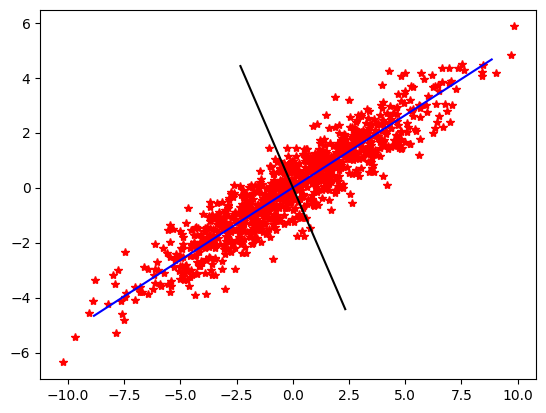

[114.30265101  19.1551027 ]


In [ ]:
plt.plot(Data[:,0],Data[:,1],'r*', Line_v1[:,0], Line_v1[:,1], 'b', Line_v2[:,0], Line_v2[:,1],'k')
plt.show()
print(S)

In [ ]:
variance = S[0]**2/np.sum(S**2)
variance

0.9726833250921116

In [ ]:
print(f"The first singular vector accounts for about {variance*100:.2f}% of the variance in the data. \
It makes sense here to use $k = 1$ (i.e. reduce to one dimension).")

The first singular vector accounts for about 97.27% of the variance in the data. It makes sense here to use $k = 1$ (i.e. reduce to one dimension).


## 6. Principal Component Analysis: Real Data

Here we will perform PCA using SVD for dimension reduction particularly for data visualization (k = 2 or 3). We'll consider the following [dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) which can also be downloaded from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html).

In [ ]:
# Load the data
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()

In [ ]:
X = cancer_data.data  # Data matrix. This was A in the lecture notes
X.shape #number of samples by number of features

(569, 30)

In [ ]:
y = cancer_data.target # The data labels, either 0 or 1
y.shape

(569,)

In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([212, 357]))

Labels --> 0: Malignant
1: Benign

Split the data into train and test (i.e. new, unseen data). Even though PCA is an unsupervised machine learning technique, the purpose of splitting the data into train and test is to show you how you could transform new, unseen data onto the low-dimensional space (e.g. what to do if you have a new patient/tumor sample). This is useful in many machine learning pipelines especially if we are performing a supervised learning task (e.g. classification) at the end.

In [ ]:
X_train, X_new, y_train, y_new = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_new.shape)
print(y_train.shape, y_new.shape)

(455, 30) (114, 30)
(455,) (114,)


In [ ]:
df_describe = pd.DataFrame(data = X_train, columns = cancer_data.feature_names)
df_describe.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.117635,19.185033,91.882242,654.377582,0.095744,0.103619,0.088898,0.048280,0.181099,0.062757,...,16.235103,25.535692,107.103121,876.987033,0.131532,0.252742,0.274595,0.114182,0.290502,0.083868
std,3.535815,4.266005,24.322027,354.943187,0.013923,0.052470,0.079468,0.038060,0.027487,0.007210,...,4.811267,6.065108,33.374664,567.672841,0.023083,0.155014,0.209398,0.065326,0.063151,0.017848
min,7.691000,9.710000,47.920000,170.400000,0.052630,0.019380,0.000000,0.000000,0.116700,0.049960,...,8.678000,12.020000,54.490000,223.600000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.705000,16.170000,75.100000,420.300000,0.085825,0.062890,0.029320,0.020340,0.161850,0.057645,...,13.055000,21.045000,84.255000,516.450000,0.114400,0.144950,0.116550,0.063930,0.249500,0.071050
50%,13.300000,18.680000,85.980000,551.700000,0.094620,0.090970,0.061540,0.033410,0.179200,0.061480,...,14.970000,25.220000,97.670000,686.600000,0.130900,0.210100,0.226400,0.098610,0.282700,0.080060
75%,15.740000,21.585000,103.750000,767.600000,0.104550,0.131300,0.132350,0.073895,0.195800,0.066100,...,18.410000,29.690000,124.650000,1031.500000,0.146050,0.341600,0.387200,0.161100,0.317750,0.092070
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.311400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.218400,0.937900,1.252000,0.291000,0.663800,0.173000


The features have drastically varying ranges. We will need to standarize the data (i.e. change the range to (0,1)) before applying PCA. Note. Sklearn uses different terminology.

Another commom preprocessing technique is to normalize the features by removing the mean and scaling to unit variance in each feature.

In [ ]:
# Check for missing data and data type
df_describe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              455 non-null    float64
 1   mean texture             455 non-null    float64
 2   mean perimeter           455 non-null    float64
 3   mean area                455 non-null    float64
 4   mean smoothness          455 non-null    float64
 5   mean compactness         455 non-null    float64
 6   mean concavity           455 non-null    float64
 7   mean concave points      455 non-null    float64
 8   mean symmetry            455 non-null    float64
 9   mean fractal dimension   455 non-null    float64
 10  radius error             455 non-null    float64
 11  texture error            455 non-null    float64
 12  perimeter error          455 non-null    float64
 13  area error               455 non-null    float64
 14  smoothness error         4

No missing data for this dataset.


HW. Research ways to handle missing data (which is very common in real data).

<Axes: >

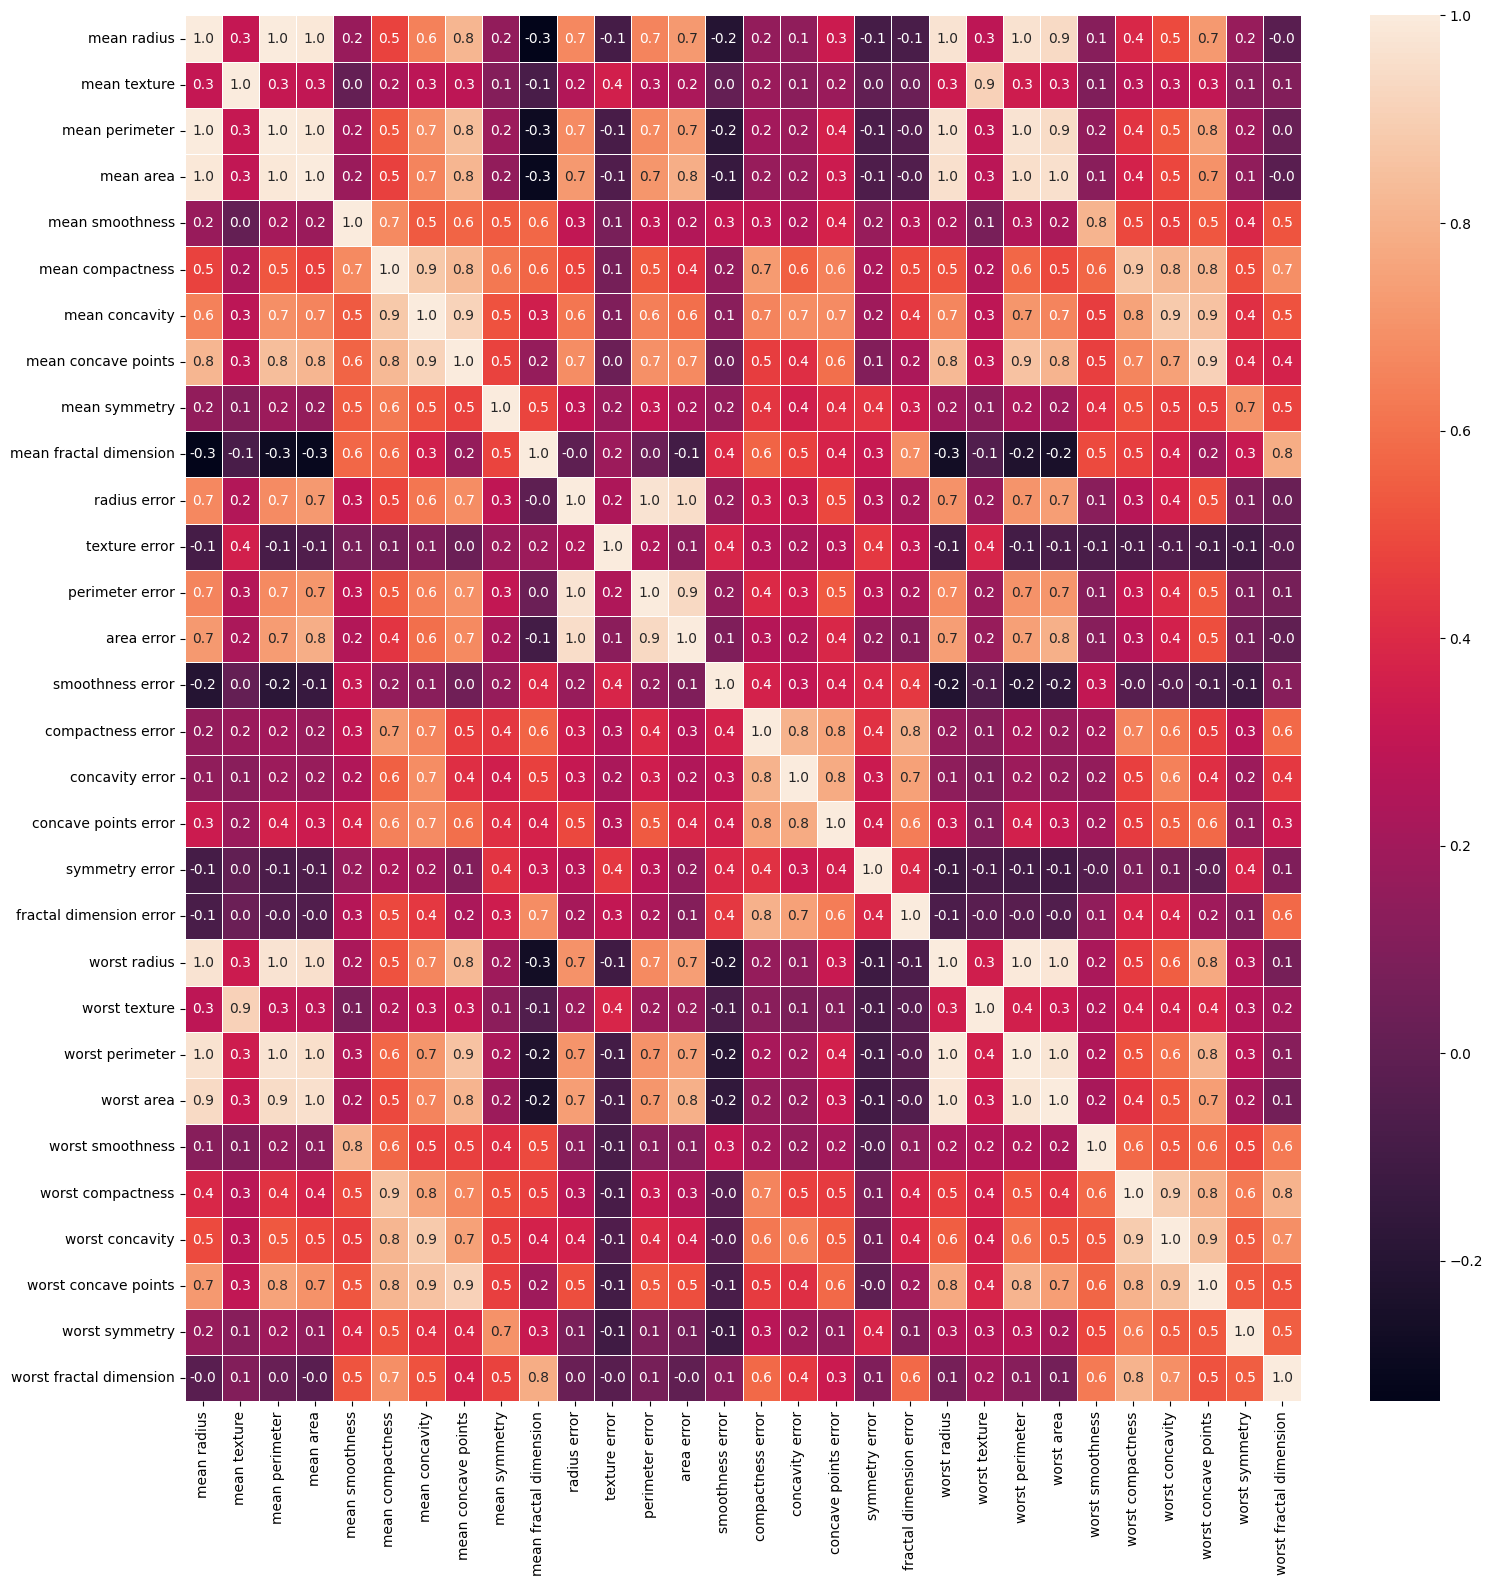

In [ ]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df_describe.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [ ]:
# Standarize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
# Center the data for PCA
mu = np.mean(X_train,axis = 0, keepdims = True)
X_train_tilde = X_train - mu
X_train_tilde.shape

(455, 30)

In [ ]:
U,S,VT = np.linalg.svd(X_train_tilde, full_matrices=False)

In [ ]:
# X_2D = U[:,0:2]@np.diag(S[0:2])
# Or
X_2D = np.dot(X_train_tilde,VT[0:2,:].T)
X_2D.shape

(455, 2)

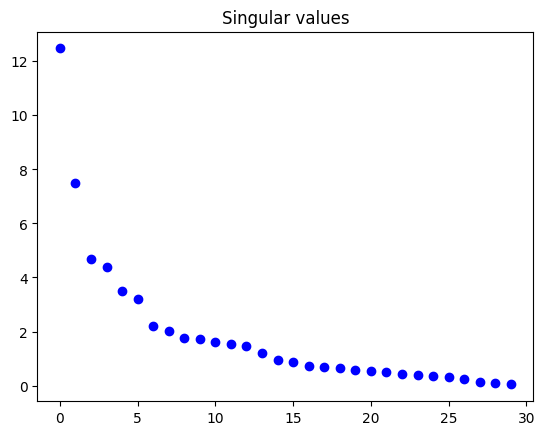

In [ ]:
plt.plot(S,'bo')
plt.title('Singular values')
plt.show()

In [ ]:
variance = (S[0]**2+S[1]**2)/np.sum(S**2)
variance

0.6982598708346214

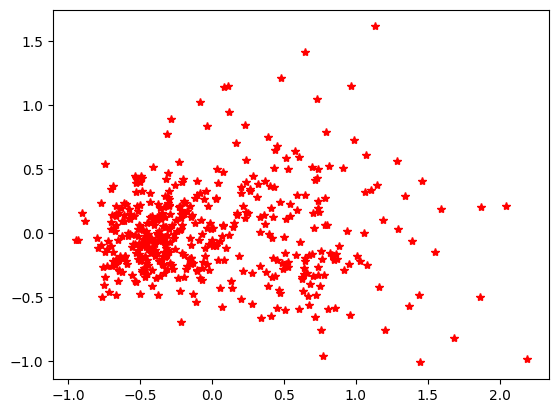

In [ ]:
fig = plt.figure()
plt.plot(X_2D[:,0],X_2D[:,1],'*r')
plt.show()

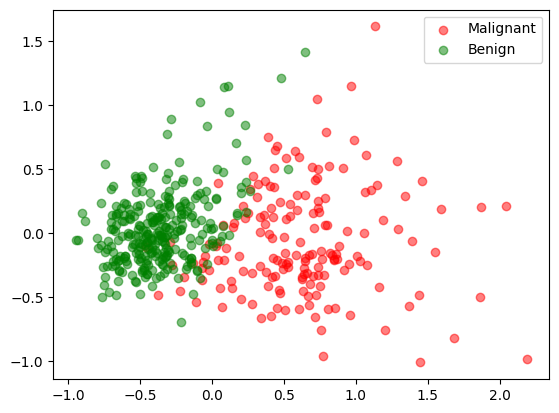

In [ ]:
fig = plt.figure()
colors = ['red', 'green']
labels = ["Malignant", "Benign"]
for i in range(0,2):
    plt.scatter(X_2D[:,0][y_train == i],X_2D[:,1][y_train == i], color = colors[i], alpha=0.5, label= labels[i])
plt.legend()
plt.show()

In the above plot, its clearer that there are two classes. If you were looking to make an algorithm that classifies these masses into the correct classes, you can imagine that first using PCA to get the above gives you a good **representation** of the data that makes classification easy.

In [ ]:
X_3D = X_train_tilde@VT[0:3,:].T
X_3D.shape

(455, 3)

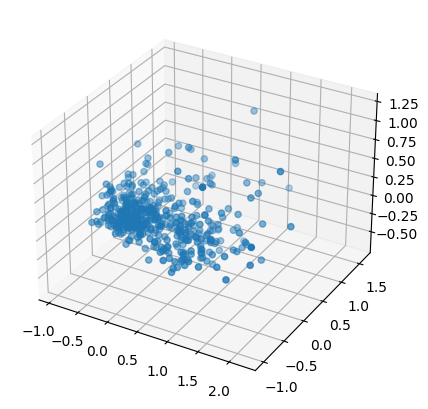

In [ ]:
#%matplotlib notebook
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2])
plt.show()

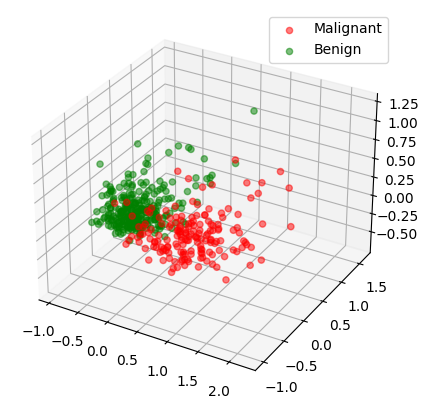

In [ ]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green']
labels = ["Malignant", "Benign"]

for i in range(0,2):
    ax.scatter(X_3D[:,0][y_train == i],X_3D[:,1][y_train == i],X_3D[:,2][y_train == i],
                color = colors[i], alpha=0.5, label= labels[i])
plt.legend()
plt.show()

In [ ]:
variance = (S[0]**2+S[1]**2+S[2]**2)/np.sum(S**2)
variance

0.7703297241569141

#### Supoose you now new unseen data. What do we do?

In [ ]:
# Standarize the features
X_new = scaler.transform(X_new) # Notice we don't fit the transformer to the test data we only transform

In [ ]:
# Center the data for PCA
X_new_tilde = X_new - mu
X_new_tilde.shape

(114, 30)

In [ ]:
# Apply learnt PCA model (i.e. the linear transformation that maps the data from high to low-dimensional space)
X_new_2D = X_new_tilde@VT[0:2,:].T
X_new_2D

array([[-0.12283273,  0.11896198],
       [ 0.46658592, -0.63061377],
       [ 0.29845084, -0.12176258],
       [-0.17782357,  0.3249755 ],
       [-0.32459551,  0.28156379],
       [ 1.75530471,  0.33159068],
       [ 1.22432393, -0.47750952],
       [ 0.28665324, -0.23353389],
       [ 0.26422178,  0.40456491],
       [-0.4516024 , -0.29238346],
       [-0.4198764 , -0.24668945],
       [ 0.19547924, -0.31928645],
       [-0.43351426, -0.42113651],
       [ 0.29620792,  0.0954115 ],
       [-0.41380078, -0.08941066],
       [ 0.81247994,  0.03671716],
       [-0.4007496 , -0.35066682],
       [-0.66795599,  0.13103356],
       [-0.8074538 ,  0.54549339],
       [ 0.91610035, -0.32463598],
       [ 0.0298607 ,  0.07336915],
       [-0.32186731,  0.06914326],
       [ 1.36321143, -0.07902631],
       [-0.75532118, -0.03965327],
       [-0.52083235, -0.05065073],
       [-0.17325491,  0.21332233],
       [-0.3112185 , -0.12046986],
       [-0.36465439,  0.18671795],
       [-0.36609109,

HW. Brainstorm other data exploration that could be done on this dataset.

### We now repeat the above experiments with sklearn built-in PCA function
The purpose is to show the different commands and options. See [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tilde)
var = pca.explained_variance_ratio_
var

array([0.51233608, 0.18592379])

In [ ]:
variance = np.sum(var)
variance

0.6982598708346214

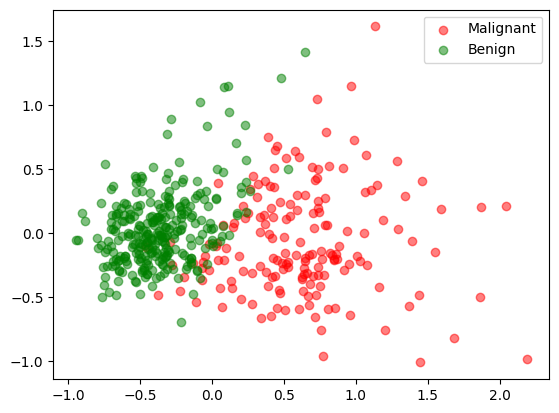

In [ ]:
fig = plt.figure()
colors = ['red', 'green']
labels = ["Malignant", "Benign"]
for i in range(0,2):
    plt.scatter(X_train_pca[:,0][y_train == i],X_train_pca[:,1][y_train == i],
                color = colors[i], alpha=0.5, label= labels[i])
plt.legend()
plt.show()

In [ ]:
X_new_pca = pca.transform(X_new_tilde)
X_new_pca

array([[-0.12283273,  0.11896198],
       [ 0.46658592, -0.63061377],
       [ 0.29845084, -0.12176258],
       [-0.17782357,  0.3249755 ],
       [-0.32459551,  0.28156379],
       [ 1.75530471,  0.33159068],
       [ 1.22432393, -0.47750952],
       [ 0.28665324, -0.23353389],
       [ 0.26422178,  0.40456491],
       [-0.4516024 , -0.29238346],
       [-0.4198764 , -0.24668945],
       [ 0.19547924, -0.31928645],
       [-0.43351426, -0.42113651],
       [ 0.29620792,  0.0954115 ],
       [-0.41380078, -0.08941066],
       [ 0.81247994,  0.03671716],
       [-0.4007496 , -0.35066682],
       [-0.66795599,  0.13103356],
       [-0.8074538 ,  0.54549339],
       [ 0.91610035, -0.32463598],
       [ 0.0298607 ,  0.07336915],
       [-0.32186731,  0.06914326],
       [ 1.36321143, -0.07902631],
       [-0.75532118, -0.03965327],
       [-0.52083235, -0.05065073],
       [-0.17325491,  0.21332233],
       [-0.3112185 , -0.12046986],
       [-0.36465439,  0.18671795],
       [-0.36609109,

## Compress a single Image
The AT&T face dataset, “(formerly ‘The ORL Database of Faces’), contains a set of face images taken between April 1992 and April 1994 at the lab. The database was used in the context of a face recognition project carried out in collaboration with the Speech, Vision and Robotics Group of the Cambridge University Engineering Department.”

Note. The dataset is already preprocessed (i.e. the images are centered, of all same dimensions, ...) which typically needs to be done for most real data.

In [ ]:
import os

# Destination directory for the downloaded file
dest_dir = "att-database-of-faces"

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)
url = "http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.tar.Z"

# Download the file using wget
!wget -P {dest_dir} {url}
# ftp://ftp.uk.research.att.com/pub/data/att_faces.tar.Z

# Extract the file using tar and uncompress
!tar -xf {dest_dir}/att_faces.tar.Z -C {dest_dir}
!uncompress {dest_dir}/att_faces.tar

print(f"File downloaded and extracted to: {dest_dir}")

URL transformed to HTTPS due to an HSTS policy
--2024-10-16 01:58:35--  https://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.tar.Z
Resolving www.cl.cam.ac.uk (www.cl.cam.ac.uk)... 128.232.0.20, 2a05:b400:110::80:14
Connecting to www.cl.cam.ac.uk (www.cl.cam.ac.uk)|128.232.0.20|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.tar.Z [following]
--2024-10-16 01:58:35--  https://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.tar.Z
Reusing existing connection to www.cl.cam.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 4075767 (3.9M) [application/x-compress]
Saving to: ‘att-database-of-faces/att_faces.tar.Z’

att_faces.tar.Z     100%[===================>]   3.89M  3.58MB/s    in 1.1s    

2024-10-16 01:58:37 (3.58 MB/s) - ‘att-database-of-faces/att_faces.tar.Z’ saved [4075767/4075767]

gzip: att-database-of-faces/att_faces.tar: unknown 

In [ ]:
# Input paths
BASE = 'att-database-of-faces/orl_faces/'

array([[48, 49, 45, ..., 56, 56, 54],
       [45, 52, 39, ..., 52, 50, 51],
       [45, 50, 42, ..., 48, 53, 50],
       ...,
       [50, 48, 50, ..., 45, 46, 46],
       [45, 54, 49, ..., 46, 47, 47],
       [51, 51, 51, ..., 47, 46, 46]], dtype=uint8)
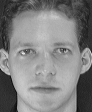

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure()
img = cv2.imread(BASE + 's1/1.pgm', 0) # '0' for reading grayscale images
img

In [ ]:
img = img/255 # convert to (0,1) range

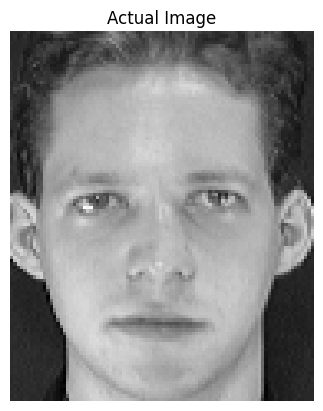

(112, 92)


In [ ]:
IMG_SHAPE = img.shape
plt.imshow(img, cmap='gray')
plt.title("Actual Image")
plt.axis('off')
plt.show()

print(IMG_SHAPE)

In [ ]:
112*92

10304

In [ ]:
U,S,VT = np.linalg.svd(img)

In [ ]:
k=15

# Choosing the first k columns of VT
V_reduced = VT[0:k,:].T

# Choosing the first k columns of U
U_reduced = U[:, 0:k]

# Choosing the k largest singular values
S_reduced = np.diag(S[0:k])

# Computing the k basis image vectors
Z = S_reduced@V_reduced.T

In [ ]:
A_0 = np.dot(U_reduced, Z)

<function matplotlib.pyplot.show(close=None, block=None)>

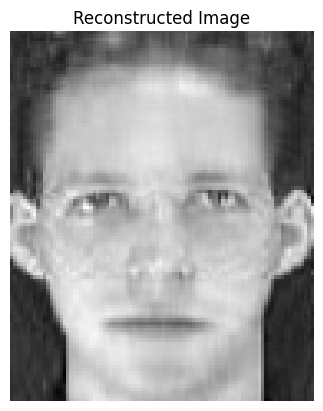

In [ ]:
plt.imshow(A_0, cmap = 'gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.show

In [ ]:
15*112 + 15*92 + 15

3075

What this means is that instead of storing all $112\times92 = 10304$ pixel values, we can instead store the first $15$ left singular vectors, the first $15$ right singular vectors and the first $15$ singular values. Thus, we need only store $15\times 112 + 15\times 92 + 15 = 3075$ numbers.

This is the basis of **image compression**

## 7. Best Rank k approximation: Real Data

We also consider here the AT&T face dataset.

In [ ]:
# Input Paths
BASE = 'att-database-of-faces/orl_faces/'

array([[48, 49, 45, ..., 56, 56, 54],
       [45, 52, 39, ..., 52, 50, 51],
       [45, 50, 42, ..., 48, 53, 50],
       ...,
       [50, 48, 50, ..., 45, 46, 46],
       [45, 54, 49, ..., 46, 47, 47],
       [51, 51, 51, ..., 47, 46, 46]], dtype=uint8)
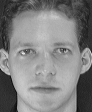

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure()
img = cv2.imread(BASE + 's1/1.pgm', 0) # '0' for reading grayscale images
img

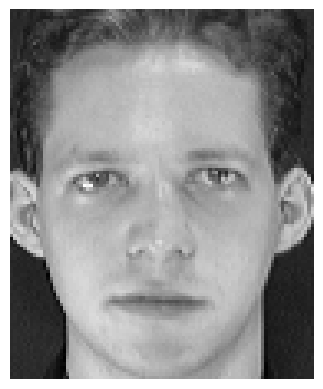

(112, 92)


In [ ]:
img = img/255

IMG_SHAPE = img.shape
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

print(IMG_SHAPE)

In [ ]:
# Creating a dataframe
filepaths = [] # Contains the absolute paths of all the image files
for s_i in os.listdir(BASE): # The folders containing the files are labelled as s1, s2, etc
    if s_i != 'README': # There is also a README file present in the data, this must be ignored
        for filename in os.listdir(BASE + s_i):
            filepaths.append(BASE + s_i + '/' + filename)

In [ ]:
df = pd.DataFrame({'filepaths':filepaths})
df.head()

,filepaths
0,att-database-of-faces/orl_faces/s6/8.pgm
1,att-database-of-faces/orl_faces/s6/7.pgm
2,att-database-of-faces/orl_faces/s6/5.pgm
3,att-database-of-faces/orl_faces/s6/3.pgm
4,att-database-of-faces/orl_faces/s6/2.pgm


In [ ]:
images = []
for filepath in df['filepaths']:
    images.append(cv2.imread(filepath, 0).flatten())
images = np.array(images)/255

In [ ]:
# We first calculate the means along each dimension
featurewise_means = np.mean(images, axis=0)

# Mean Normalization:
X = images - featurewise_means

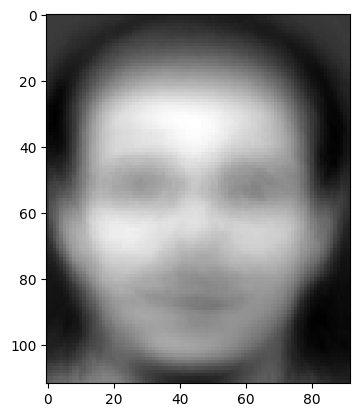

In [ ]:
# Average Face
fig = plt.figure()
plt.imshow(featurewise_means.reshape(IMG_SHAPE), cmap = 'gray')
plt.show()

The Average Face!

In [ ]:
# Computing the singular value decomposition of the covariance matrix:
U, S, VT = np.linalg.svd(X.T)

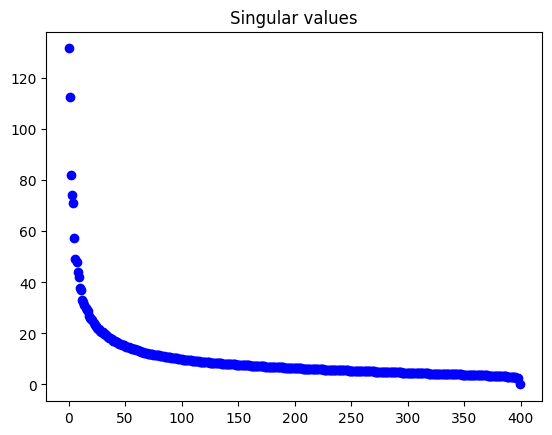

In [ ]:
plt.plot(S,'bo')
plt.title('Singular values')
plt.show()

In [ ]:
# The reduced dimensionality
k = 100

In [ ]:
print(U.shape,S.shape,VT.shape)

(10304, 10304) (400,) (400, 400)


In [ ]:
# Choosing the first k columns of VT
V_reduced = VT[0:k,:]

# Choosing the first k columns of U
U_reduced = U[:, 0:k]

# Choosing the k largest singular values
S_reduced = np.diag(S[0:k])

# Computing the k basis image vectors
Z = U_reduced@S_reduced

In [ ]:
Z.shape

(10304, 100)

In [ ]:
print(U_reduced.shape,S_reduced.shape,V_reduced.shape)

(10304, 100) (100, 100) (100, 400)


In [ ]:
Z[:,i].shape

(10304,)

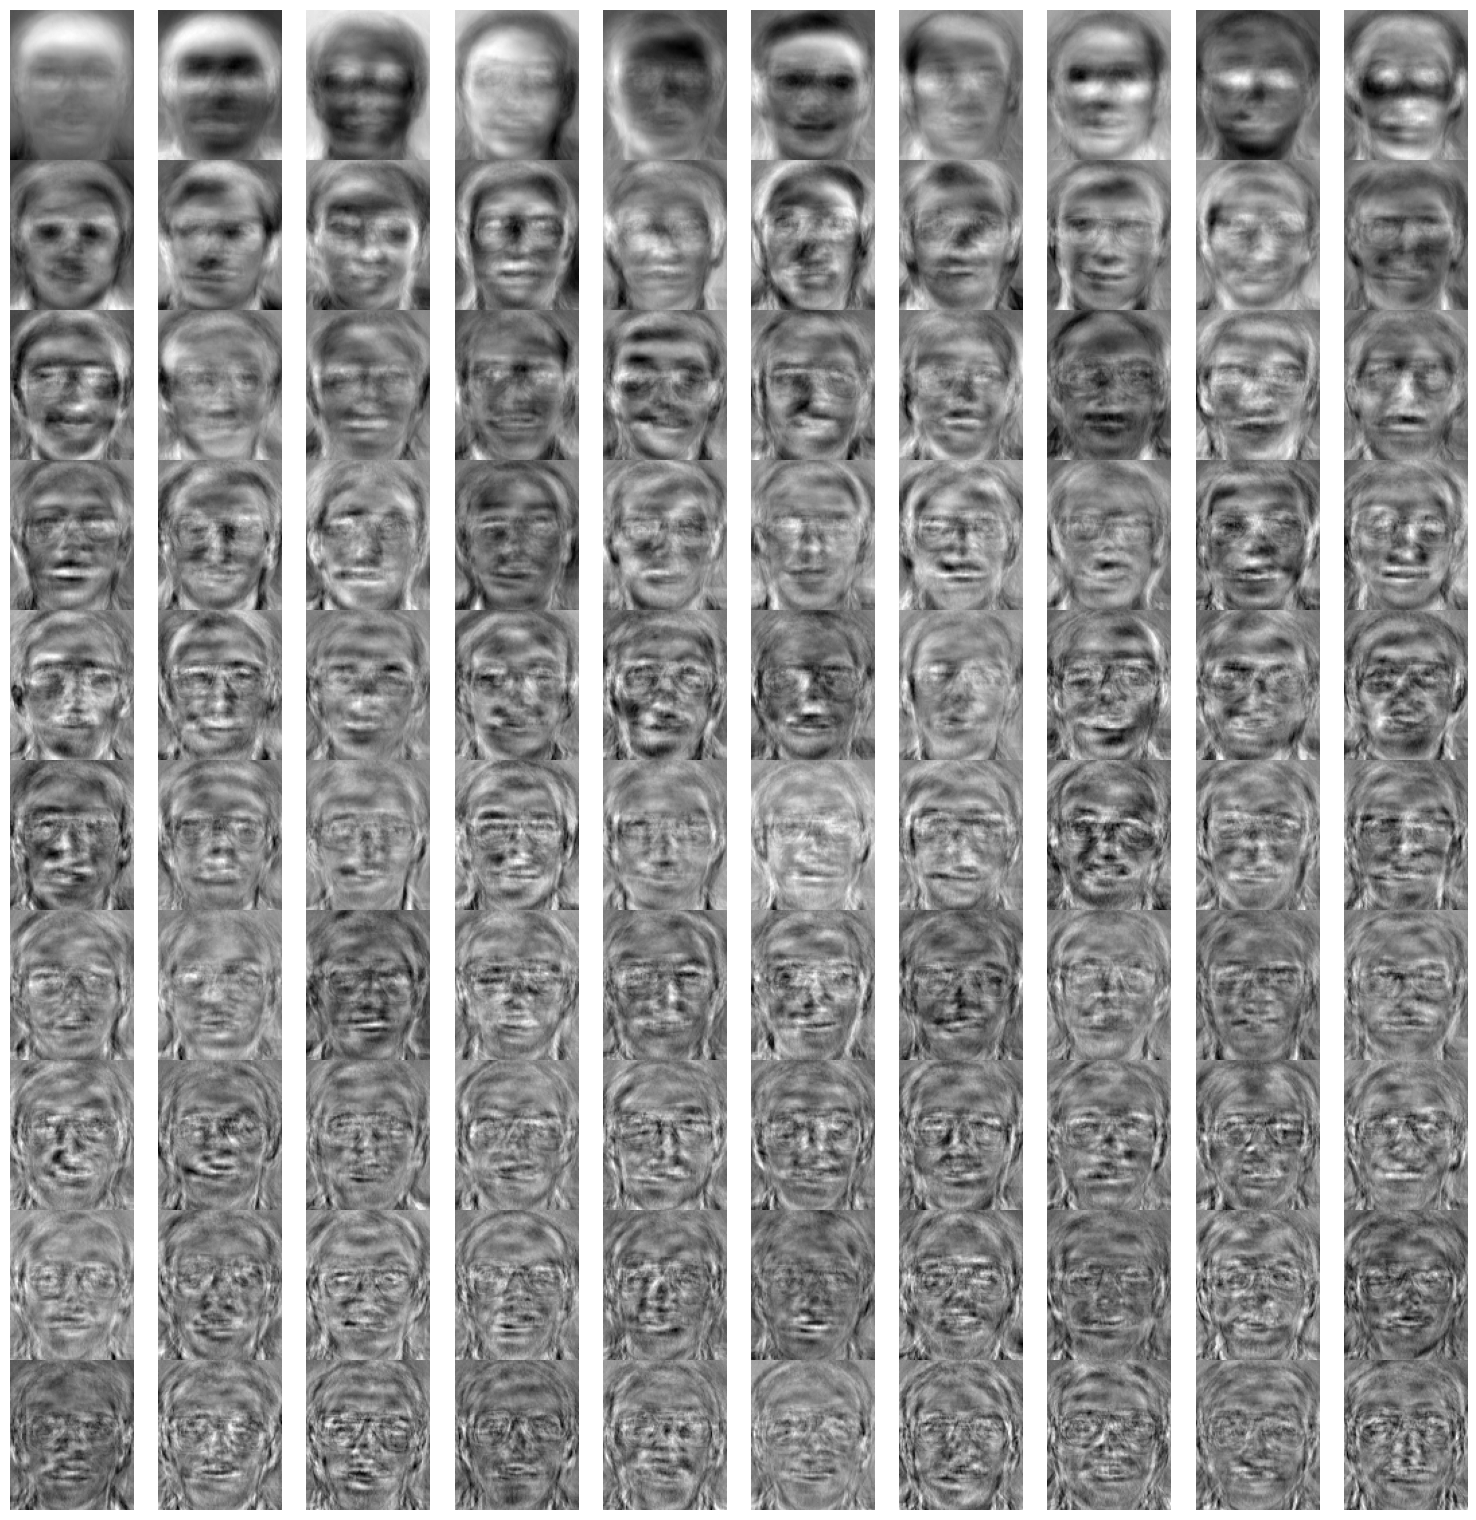

In [ ]:
# Displaying the basis image vectors (called eigenfaces)
fig, axes = plt.subplots(10, 10, figsize = (15, 15))
for (ax,i) in zip(axes.flat, range(Z.shape[1])):
    ax.imshow(Z[:,i].reshape(IMG_SHAPE), cmap = 'gray')
    ax.axis('off')
fig.tight_layout(pad = 0)

These are called eigenfaces!

In [ ]:
Z.shape

(10304, 100)

In [ ]:
V_reduced[:,0].shape

(100,)

In [ ]:
A_0 = Z@V_reduced[:,0] + featurewise_means
A_0.shape

(10304,)

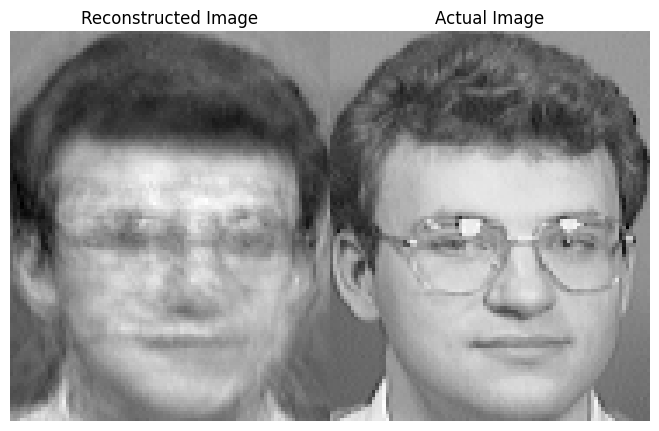

In [ ]:
# Reconstructing the 0th image:
# Displaying the images:
A_0 = A_0.reshape(IMG_SHAPE)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Reconstructed Image')
plt.imshow(A_0, cmap='gray')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Actual Image')
plt.imshow(images[0].reshape(IMG_SHAPE), cmap='gray')
plt.tight_layout(pad = 0)
plt.show()

HW. Apply on another image dataset of your own.

## 8. SVD for Spiked Data

A spiked matrix is a matrix of the form $A = \mathbf{u}\mathbf{v}^{\top} + \varepsilon B$, where $\varepsilon$ is a small number. We usually think of $\mathbf{u},\mathbf{v}$ as the signal, and $B$ as noise. SVD is very good at separating signal from noise in this situation, as we'll demonstrate in the next block of code.

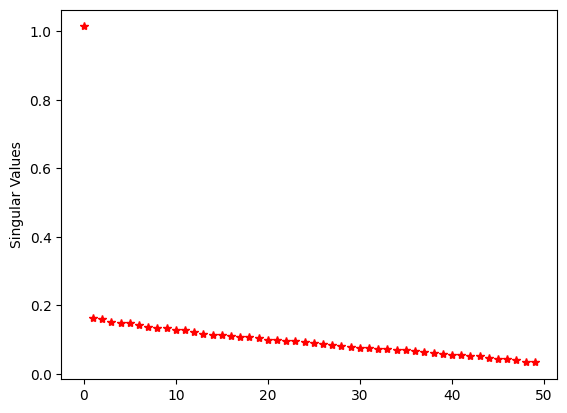

In [ ]:
Noise_part = np.random.randn(100,50)
u1 = np.zeros([100,1])
u1[0] = 1
v1 = np.zeros([1,50])
v1[0,0] = 1
# print(v1)
epsilon = 0.01
Rank_one_part = np.dot(u1,v1)
A =Rank_one_part + epsilon*Noise_part
U,S,Vh = np.linalg.svd(A)
plt.plot(S,'r*')
plt.ylabel('Singular Values')
plt.show()

Thus, the singular values provide excellent evidence that $A$ is spiked. The first singular vectors will be an excellent approximation to the signal:

In [ ]:
u1_tilde = np.round(np.reshape(U[:,0],(100,1)),2)
print(np.concatenate((u1,u1_tilde),axis = 1))

[[ 1.   -1.  ]
 [ 0.   -0.01]
 [ 0.   -0.  ]
 [ 0.    0.  ]
 [ 0.    0.01]
 [ 0.    0.  ]
 [ 0.   -0.01]
 [ 0.   -0.01]
 [ 0.   -0.02]
 [ 0.   -0.01]
 [ 0.    0.  ]
 [ 0.    0.01]
 [ 0.   -0.  ]
 [ 0.    0.  ]
 [ 0.   -0.  ]
 [ 0.    0.  ]
 [ 0.    0.  ]
 [ 0.    0.  ]
 [ 0.    0.01]
 [ 0.    0.01]
 [ 0.    0.01]
 [ 0.   -0.01]
 [ 0.    0.02]
 [ 0.    0.03]
 [ 0.    0.01]
 [ 0.    0.  ]
 [ 0.   -0.01]
 [ 0.   -0.  ]
 [ 0.    0.01]
 [ 0.   -0.01]
 [ 0.    0.  ]
 [ 0.    0.01]
 [ 0.   -0.  ]
 [ 0.    0.01]
 [ 0.    0.01]
 [ 0.   -0.  ]
 [ 0.   -0.  ]
 [ 0.    0.01]
 [ 0.    0.  ]
 [ 0.    0.01]
 [ 0.   -0.01]
 [ 0.   -0.02]
 [ 0.   -0.01]
 [ 0.   -0.01]
 [ 0.    0.  ]
 [ 0.    0.01]
 [ 0.    0.  ]
 [ 0.    0.  ]
 [ 0.   -0.  ]
 [ 0.    0.01]
 [ 0.    0.  ]
 [ 0.    0.01]
 [ 0.    0.01]
 [ 0.   -0.01]
 [ 0.    0.01]
 [ 0.    0.01]
 [ 0.    0.02]
 [ 0.   -0.02]
 [ 0.    0.  ]
 [ 0.   -0.01]
 [ 0.   -0.  ]
 [ 0.    0.01]
 [ 0.    0.01]
 [ 0.   -0.01]
 [ 0.   -0.01]
 [ 0.   -0.  ]
 [ 0.    0

We can expand the definition of spiked matrix to any matrix of the form: $A = (\text{low rank part}) + \varepsilon (\text{noise})$.

Exercise: Experiment with adding a rank 2 or 3 spike to $A$, and see what happens to the singular values.

## Exploratory Topic: Missing Data Imputation

## Exploratory Topic: Noise Reduction

## 7. Many more applications

HW. List one more application of SVD.